# Finding Motion vectors

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from image_comression import *
from run_length import *

In [2]:
def sum_of_absolute_difference(image1,image2):
    diff = np.abs(image1 - image2)
    sad = np.sum(diff)
    return sad

# Searching for a simmilar block

Sequential search

In [3]:
def sequential_search(block,frame_100):
    block_height, block_width = block.shape  # Get block dimensions
    frame2_height,frame2_width = frame_100.shape
    min_sad = np.inf  # Initialize minimum SAD
    best_match_x = 0
    best_match_y = 0
    itter_2 = 0
    for y in range(0, frame2_height - block_height):
        for x in range(0, frame2_width - block_width):
            itter_2 = itter_2 + 1
            candidate_block = frame_100[y:y+block_height, x:x+block_width]

            # Calculate SAD between the block and candidate block
            sad = np.sum(np.abs(block - candidate_block))

            # Update best match if SAD is lower
            if sad < min_sad:
                min_sad = sad
                best_match_x = x
                best_match_y = y

    return best_match_x,best_match_y

logarithmic search (Much faster but not that acurate)

In [ ]:
import numpy as np

def logarithmic_search_2d(frame, block,curent_x,current_y):
    block_height, block_width = block.shape
    frame2_height, frame2_width = frame.shape

    if block_height > frame2_height or block_width > frame2_width:
        raise ValueError("Block dimensions exceed frame dimensions.")

    search_range = max(frame2_height, frame2_width) // 2
    # best_match_x, best_match_y = frame2_width // 2, frame2_height // 2
    best_match_x, best_match_y = curent_x,current_y
    min_sad = np.inf
    itter = 0
    while search_range >= 1:
        # Generate nine candidate positions in the current search window
        candidates = [(best_match_x + i * search_range, best_match_y + j * search_range)
                      for i in [-1, 0, 1] for j in [-1, 0, 1]]

        # Filter out candidates that exceed frame boundaries
        candidates = [(x, y) for x, y in candidates
                      if 0 <= x < frame2_width - block_width + 1 and 0 <= y < frame2_height - block_height + 1]

        for x, y in candidates:
            itter = itter + 1
            candidate_block = frame[y:y + block_height, x:x + block_width]
            sad = np.sum(np.abs(block - candidate_block))

            if sad < min_sad:
                min_sad = sad
                best_match_x, best_match_y = x, y

        # Update search range for the next iteration (reduce by half)
        search_range //= 2

    return best_match_x, best_match_y, min_sad,itter


# Obtaining motion vectors for all macro blocks

Dividing the second frame into macro blocks and finding the motion vectors for macro blocks

In [ ]:
from PIL import Image
image_array = frame_2
height, width = image_array.shape
pad_height = (8 - height % 8) % 8
pad_width = (8 - width % 8) % 8

# Pad the image with zeros
padded_image = np.pad(image_array, ((0, pad_height), (0, pad_width)), 'constant')

# Calculate the number of blocks in each dimension
num_blocks_h = padded_image.shape[0] // 8
num_blocks_w = padded_image.shape[1] // 8

blocks_1 = np.empty((0, 8, 8))
blocks_2 = np.empty((0, 8, 8))

motion_vectors = []
changed = []

for i in range(num_blocks_h):
    for j in range(num_blocks_w):
        start_x = j*8
        end_x = start_x + 8
        start_y = i*8
        end_y = start_y+8
        block_1 = frame_1[start_x:end_x,start_y:end_y]
        block_2 = frame_2[start_x:end_x,start_y:end_y]

        blocks_1 = np.concatenate((blocks_1, [block_1]), axis=0)
        blocks_2 = np.concatenate((blocks_2, [block_2]), axis=0)

        SAD = sum_of_absolute_difference(block_1,block_2)
        print(SAD)
        #check SAD
        if SAD > 6000:
            # best_match_x, best_match_y, min_sad,itter = logarithmic_search_2d(frame_1, block_2,start_x,start_y)
            best_match_x, best_match_y = sequential_search(block_2,frame_2[start_x-8:end_x+8,start_y-8:end_y+8])
            # best_match_x, best_match_y = start_x,start_y
            motion_vector = best_match_x, best_match_y,True
            changed.append((best_match_x, best_match_y))
        else:
            best_match_x, best_match_y = start_x,start_y
            motion_vector = best_match_x, best_match_y,False
        motion_vectors.append(motion_vector)

In [ ]:
num = 78
print(len(changed))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))  # Adjust figsize as needed
best_match_log = frame_1[changed[num][0]:changed[num][0]+8,changed[num][1]:changed[num][1]+8]
ax1.imshow(blocks_2[num], cmap="gray")
ax2.imshow(best_match_log, cmap="gray")

# Creating the Predicted current frame

In [ ]:
blocks = np.empty((0, 8, 8))
for motion_vector in motion_vectors:
    if motion_vector[2]:
        block = frame_1[motion_vector[0]:motion_vector[0]+8,motion_vector[1]:motion_vector[1]+8]
        blocks = np.concatenate((blocks, [block]), axis=0)
        
    else:
        block = frame_2[motion_vector[0]:motion_vector[0]+8,motion_vector[1]:motion_vector[1]+8]
        blocks = np.concatenate((blocks, [block]), axis=0)
print(blocks.shape)

In [ ]:
def reconstruct_from_blocks(blocks):
    reconstructed = np.zeros(padded_image.shape)

    block_number = 0
    for i in range(80):
        for j in range(80):
            start_x = j*8
            end_x = start_x + 8
            start_y = i*8
            end_y = start_y+8
            reconstructed[start_x:end_x,start_y:end_y] = blocks[block_number]
            block_number = block_number + 1
    
    return reconstructed

In [ ]:
index_list = []
for index,block in enumerate(blocks):
    SAD = sum_of_absolute_difference(block,blocks_1[index])
    if SAD>0:
        index_list.append(index)

In [ ]:
inex = index_list[74]
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10, 6))  # Adjust figsize as needed
ax1.imshow(frame_1[motion_vectors[inex][0]:motion_vectors[inex][0]+8,motion_vectors[inex][1]:motion_vectors[inex][1]+8], cmap="gray")
ax2.imshow(blocks_1[inex], cmap="gray")
ax3.imshow(blocks_2[inex], cmap="gray")
# ax4.imshow(blocks[inex], cmap="gray")

In [ ]:
predicted_current_frame = reconstruct_from_blocks(blocks)
plt.imshow(predicted_current_frame, cmap="gray")
print(np.max(predicted_current_frame))

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10, 6))  # Adjust figsize as needed
ax1.imshow(frame_1, cmap="gray")
ax2.imshow(frame_2, cmap="gray")
ax3.imshow(predicted_current_frame, cmap="gray")

In [ ]:
# residual = reconstructed - frame_2
residual = (frame_2 - predicted_current_frame).astype(int)
plt.imshow(residual,cmap='gray')

In [ ]:
plt.imshow(residual+predicted_current_frame,cmap='gray')

In [ ]:
compressed_residual_string = compress_complete_image(residual,0.3)

In [ ]:
print(compressed_residual_string)

In [ ]:
print(len(compressed_residual_string)/8000)

In [ ]:
reconstructed_residual = decompress_complete_image()

In [ ]:
plt.imshow(reconstructed_residual,cmap='gray')

In [ ]:
reconstructed_frame_2 = reconstructed_residual*5 + predicted_current_frame
plt.imshow(reconstructed_frame_2,cmap='gray')

In [ ]:
print(np.max(reconstructed_residual))
print(np.max(residual))

# Loading 10 frames

In [4]:
frames = np.empty((0, 640, 640))

for i in range(70,180,10):
    frame = cv2.resize(cv2.imread(f"test_frames_2/frame_{i}.png",0), (640, 640))
    frames = np.concatenate((frames, [frame]), axis=0)
print(frames.shape)

(11, 640, 640)


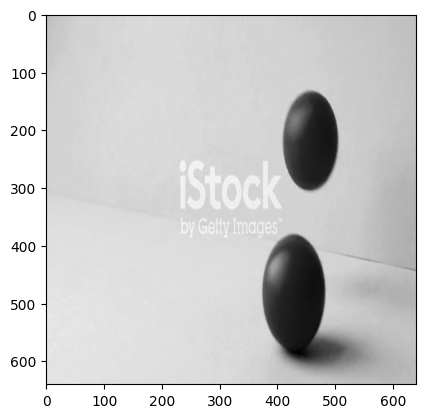

In [5]:
plt.imshow(frames[1],cmap='gray')

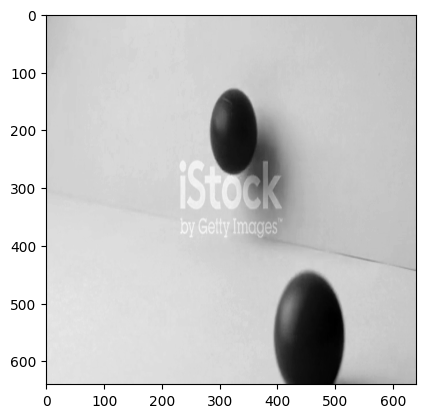

In [6]:
plt.imshow(frames[2],cmap='gray')

# Obtaining motion vectors

In [7]:
motion_vectors_frames = []
predicted_current_frames = np.empty((0, 640, 640))
residuals = np.empty((0,640,640))

for index,current_frame in enumerate(frames):
    if index == 0:
        continue
    #find motion vectors for the frame
    else:
        frame_motion_vectors = []
        changed = []

        for i in range(80):
            for j in range(80):
                start_x = j*8
                end_x = start_x + 8
                start_y = i*8
                end_y = start_y+8
                previous_frame_block = frames[index-1][start_x:end_x,start_y:end_y]
                # print("pre-",previous_frame_block)
                current_frame_block = current_frame[start_x:end_x,start_y:end_y]
                # print('cur',current_frame_block)
                SAD = sum_of_absolute_difference(previous_frame_block,current_frame_block)
                print("SAD ",SAD)
                #check SAD
                if SAD > 1000:
                    print("here")
                    # best_match_x, best_match_y, min_sad,itter = logarithmic_search_2d(frame_1, block_2,start_x,start_y)
                    best_match_x, best_match_y = sequential_search(current_frame_block,frames[index-1][start_x-32:end_x+32,start_y-32:end_y+32])
                    # best_match_x, best_match_y = start_x,start_y
                    motion_vector = best_match_x, best_match_y,True
                    changed.append((best_match_x, best_match_y))
                else:
                    print("here 2")
                    best_match_x, best_match_y = start_x,start_y
                    motion_vector = best_match_x, best_match_y,False
                frame_motion_vectors.append(motion_vector)
        motion_vectors_frames.append(frame_motion_vectors)

SAD  0.0
here 2
SAD  12.0
here 2
SAD  10.0
here 2
SAD  13.0
here 2
SAD  14.0
here 2
SAD  23.0
here 2
SAD  22.0
here 2
SAD  1.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  25.0
here 2
SAD  19.0
here 2
SAD  51.0
here 2
SAD  25.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  2.0
here 2
SAD  2.0
here 2
SAD  2.0
here 2
SAD  8.0
here 2
SAD  1.0
here 2
SAD  1.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  1.0
here 2
SAD  2.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  8.0
here 2
SAD  8.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  64.0
here 2
SAD  48.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  0.0
here 2
SAD  5.0
here 2
SAD  0.0
her

In [8]:
print(len(motion_vectors_frames))
print(motion_vectors_frames[0])

10
[(0, 0, False), (8, 0, False), (16, 0, False), (24, 0, False), (32, 0, False), (40, 0, False), (48, 0, False), (56, 0, False), (64, 0, False), (72, 0, False), (80, 0, False), (88, 0, False), (96, 0, False), (104, 0, False), (112, 0, False), (120, 0, False), (128, 0, False), (136, 0, False), (144, 0, False), (152, 0, False), (160, 0, False), (168, 0, False), (176, 0, False), (184, 0, False), (192, 0, False), (200, 0, False), (208, 0, False), (216, 0, False), (224, 0, False), (232, 0, False), (240, 0, False), (248, 0, False), (256, 0, False), (264, 0, False), (272, 0, False), (280, 0, False), (288, 0, False), (296, 0, False), (304, 0, False), (312, 0, False), (320, 0, False), (328, 0, False), (336, 0, False), (344, 0, False), (352, 0, False), (360, 0, False), (368, 0, False), (376, 0, False), (384, 0, False), (392, 0, False), (400, 0, False), (408, 0, False), (416, 0, False), (424, 0, False), (432, 0, False), (440, 0, False), (448, 0, False), (456, 0, False), (464, 0, False), (472, 0,

In [9]:
#these are for a single frame
def create_frame_blocks_from_motion_vectors(motion_vectors,previous_frame):
    frame_blocks = np.empty((0, 8, 8))
    for motion_vector in motion_vectors_frames[0]:
        if motion_vector[2]:
            block = previous_frame[motion_vector[0]:motion_vector[0]+8,motion_vector[1]:motion_vector[1]+8]
            frame_blocks = np.concatenate((frame_blocks, [block]), axis=0)
            
        else:
            block = previous_frame[motion_vector[0]:motion_vector[0]+8,motion_vector[1]:motion_vector[1]+8]
            frame_blocks = np.concatenate((frame_blocks, [block]), axis=0)

    return frame_blocks

def create_predicted_current_frame(frame_blocks):

    predicted_current_frame = np.zeros((640,640))

    block_number = 0
    for i in range(80):
        for j in range(80):
            start_x = j*8
            end_x = start_x + 8
            start_y = i*8
            end_y = start_y+8
            predicted_current_frame[start_x:end_x,start_y:end_y] = frame_blocks[block_number]
            block_number = block_number + 1
    
    return predicted_current_frame

def create_residual(predicted_current_frame,current_frame):
    
    residual = current_frame-predicted_current_frame
    return residual

def create_compressed_residual(residual,location,level):
    compressed_residual_string = compress_complete_image(residual,level,location)
    return compressed_residual_string

# Encoder side

In [10]:
predicted_current_frames = np.empty((0,640,640))
residuals = np.empty((0,640,640))
compressed_strings = []
level = 5

for index,motion_vector in enumerate(motion_vectors_frames):
    frame_blocks_ = create_frame_blocks_from_motion_vectors(motion_vector,frames[index])
    predicted_current_frame_ = create_predicted_current_frame(frame_blocks_)
    residual_ = create_residual(predicted_current_frame_,frames[index+1])
    compressed_residual = create_compressed_residual(residual_,f"Frame_{index + 1}.txt",level)
    
    predicted_current_frames = np.concatenate((predicted_current_frames, [predicted_current_frame_]), axis=0)
    residuals = np.concatenate((residuals, [residual_]), axis=0)
    compressed_strings.append(compressed_residual)

640 640
0 0
640 640
0 0
640 640
0 0
640 640
0 0
640 640
0 0
640 640
0 0
640 640
0 0
640 640
0 0
640 640
0 0
640 640
0 0


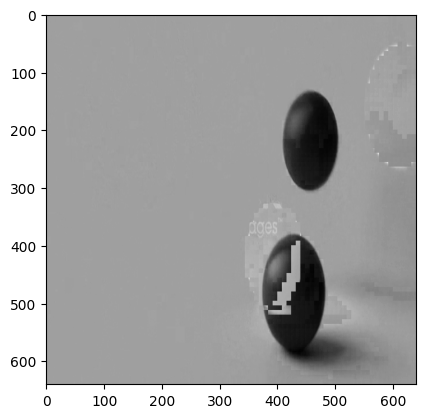

In [11]:
plt.imshow(residuals[0],cmap='gray')

# Reconstruction of frames

Obtaining decompressed residuals

In [12]:
decompressed_residuals = np.empty((0,640,640))
for i in range(len(compressed_strings)):
    decompressed_residual_ = decompress_complete_image(f"Frame_{i+1}.txt",level)
    decompressed_residuals = np.concatenate((decompressed_residuals, [decompressed_residual_]), axis=0)

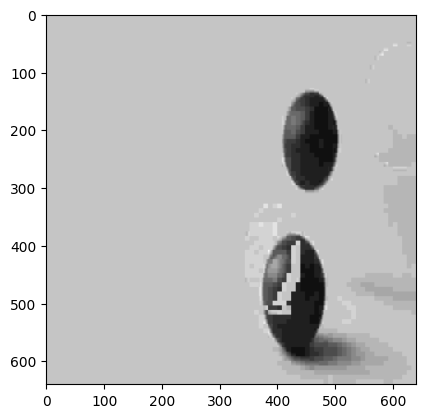

In [13]:
plt.imshow(decompressed_residuals[0],cmap='gray')

Creating predicted current frames using motion vectors (Decoder Side)

In [14]:
generated_frames = np.empty((0,640,640))
generated_frames = np.concatenate((generated_frames, [frames[0]]), axis=0)
decoder_predicted_frames = np.empty((0,640,640))

for index,motion_vector in enumerate(motion_vectors_frames):
    frame_blocks_ = create_frame_blocks_from_motion_vectors(motion_vector,generated_frames[index])
    predicted_current_frame_ = create_predicted_current_frame(frame_blocks_)
    generated_frame = predicted_current_frame_ + decompressed_residuals[index]

    decoder_predicted_frames = np.concatenate((decoder_predicted_frames, [predicted_current_frame_]), axis=0)
    generated_frames = np.concatenate((generated_frames, [generated_frame]), axis=0)

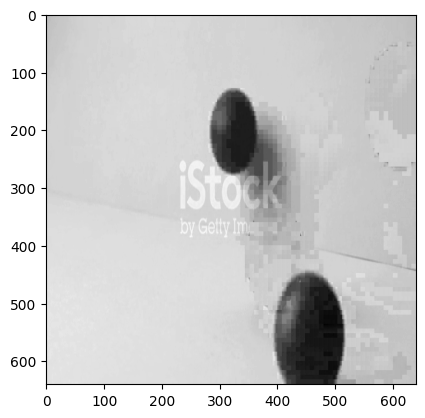

In [15]:
index = 2
# plt.imshow(decoder_predicted_frames[index]+decompressed_residuals[index],cmap='gray')
plt.imshow(generated_frames[index],cmap='gray')

In [16]:
for index,frame in enumerate(generated_frames):
    plt.imsave(f"results/frame{index}.png",frame,cmap="gray")

In [17]:
for index,frame in enumerate(frames):
    plt.imsave(f"original/frame{index}.png",frame,cmap="gray")

In [ ]:
frame_blocks = np.empty((0, 8, 8))
for motion_vector in motion_vectors_frames[0]:
    if motion_vector[2]:
        block = frames[0][motion_vector[0]:motion_vector[0]+8,motion_vector[1]:motion_vector[1]+8]
        frame_blocks = np.concatenate((frame_blocks, [block]), axis=0)
        
    else:
        block = frames[1][motion_vector[0]:motion_vector[0]+8,motion_vector[1]:motion_vector[1]+8]
        frame_blocks = np.concatenate((frame_blocks, [block]), axis=0)
print(frame_blocks.shape)

In [ ]:
frame_blocks = create_frame_blocks_from_motion_vectors(motion_vectors_frames[0],frames[0])
print(frame_blocks.shape)

In [ ]:
predicted_second_frame = reconstruct_from_blocks(frame_blocks)
plt.imshow(predicted_second_frame, cmap="gray")

In [ ]:
residual_frame_2 = frames[1] - predicted_second_frame
plt.imshow(residual_frame_2,cmap='gray')

In [ ]:
compressed_residual_string_frame_2 = compress_complete_image(residual_frame_2,0.3)

In [ ]:
reconstructed_residual_2 = decompress_complete_image()

In [ ]:
plt.imshow(reconstructed_residual_2,cmap='gray')

In [ ]:
reconstructed_second_frame = reconstructed_residual_2*5 + predicted_second_frame
plt.imshow(reconstructed_second_frame,cmap='gray')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))  # Adjust figsize as needed
ax1.imshow(frames[1], cmap="gray")
ax2.imshow(reconstructed_second_frame, cmap="gray")

In [ ]:
print(len(motion_vectors_frames[1]))

In [ ]:
used_second_frame = reconstructed_second_frame

# Third frame

In [ ]:
new_blocks = np.empty((0, 8, 8))
itter = 0

In [ ]:

for motion_vector in motion_vectors_frames[1]:
    if motion_vector[2]:
        block = used_second_frame[motion_vector[0]:motion_vector[0]+8,motion_vector[1]:motion_vector[1]+8]
        new_blocks = np.concatenate((new_blocks, [block]), axis=0)
        itter = itter + 1
    else:
        block = used_second_frame[motion_vector[0]:motion_vector[0]+8,motion_vector[1]:motion_vector[1]+8]
        new_blocks = np.concatenate((new_blocks, [block]), axis=0)
    # print(new_blocks.shape)
# print(frame_blocks.shape)
# print(itter)

In [ ]:
print(new_blocks.shape)
print(itter)

In [ ]:
predicted_third_frame = reconstruct_from_blocks(new_blocks)
plt.imshow(predicted_third_frame, cmap="gray")

In [ ]:
third_frame_residual = frames[2]-predicted_third_frame
plt.imshow(third_frame_residual,cmap='gray')

In [ ]:
compressed_residual_string_frame_3 = compress_complete_image(third_frame_residual,0.3)
reconstructed_residual_3 = decompress_complete_image()
plt.imshow(reconstructed_residual_3,cmap='gray')

In [ ]:
reconstructed_frame_3 = reconstructed_residual_3*1 + reconstructed_second_frame*6
plt.imshow(reconstructed_frame_3,cmap='gray')